## Spam Detection
The goal of this notebook is to outline the steps I used to create a spam classifier. I'll be going through some exploratory data visualization, before stepping into some data preprocessing, and then eventually applying it to a machine learning pipeline.

Throughout the process, I'll highlight things that I found interesting.

The dataset is taken from [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

### Exploratory Data Analysis
In this section I'll take a look at the dataset and see what we are dealing with. Here I use pandas, matplotlib, and seaborn.

In [1]:
# Here we're just going to open the file making sure to rstrip the file to get rid of the 
# trailing whitespace. And then we'll see the size of the dataset.
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


In [2]:
# So 5575 rows, that's not too bad.
# Let's get an idea of the sort of data we are dealing with so we enumerate and show the top 3 entries 
# in this collection
for msg_no, msg in enumerate(messages[:3]):
    print(msg_no, msg)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [3]:
# It looks like we're dealing with a tab separated file
# Let's convert that to a pandas dataframe to work with it
import pandas as pd

In [4]:
# We'll call this dataframe messages
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names=['label','message'])

In [5]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Here we see that in labels we have two labels, one is 'spam' and the other 'ham'.
# And we also see that there are some duplicate messages since unique < count
# which makes sense given that some text messages are pretty standard. eg. "Sorry, I'll call later"
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
# By grouping it by label we can see that the majority of the dataset are regular text messages (ham)
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [8]:
# It is reasonable to create a new feature for length as it could be an interesting quality for 
# text messages.
messages['len'] = messages['message'].apply(len)

In [9]:
messages.head()

,label,message,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
# Now to do some data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
%matplotlib inline

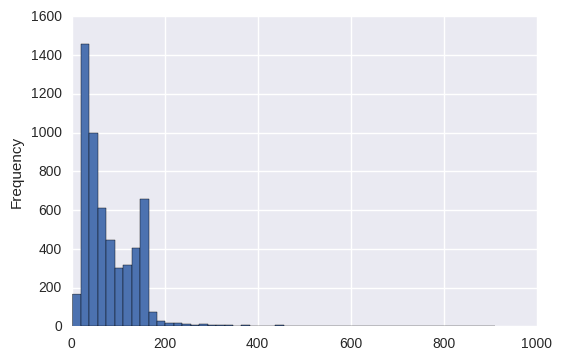

In [12]:
# Show distribution of text length
# And we see that there is some bimodal behaviour. This is sort of promising, since there is a chance
# that a differentiator between spam and ham could be the sms length.
messages['len'].plot.hist(bins=50)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc232351f28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc23239e898>], dtype=object)

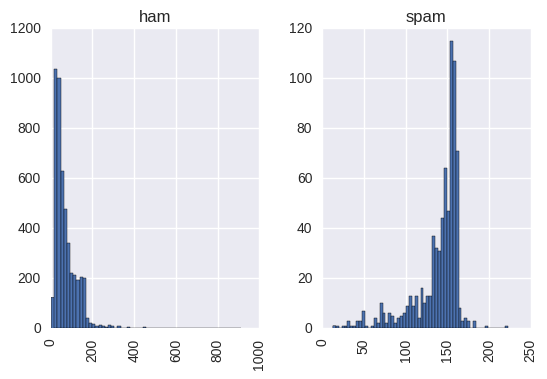

In [13]:
# And we can see that most ham messages are towards the 50 character length, while spam tends to be
# longer at around 150 characters.
messages.hist(column='len',by='label', bins=60) 

### Data Preprocessing
Here we take this text data and transform it into something that we can later use in out machine learning pipeline. We'll be changing our text messages into a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model). Nltk also provides a lot of great tools for making this process extremely simple.

In [14]:
import string

In [15]:
from nltk.corpus import stopwords

In [16]:
def clean_text(msg):
    """
    1. Remove punctuation (Provided by string)
    2. Remove stopwords (Provided by nltk)
    3. Return list of cleaned words
    """
    nopunc = [char for char in msg if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [wrd for wrd in nopunc.split() if wrd.lower() not in stopwords.words('english')]

In [17]:
# Tokenize and clean the first five entries just to see the results
messages['message'].head(5).apply(clean_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [18]:
# Vectorize words using bag of words method.
from sklearn.feature_extraction.text import CountVectorizer

bow_trans = CountVectorizer(analyzer=clean_text).fit(messages['message'])

In [19]:
# Around 11k words in vocabulary
print(len(bow_trans.vocabulary_))

11425


In [20]:
# Let's just play around on a specific message
# Here we choose the 4th message
msg4 = messages['message'][3]

In [21]:
# We apply transformation
bow4 = bow_trans.transform([msg4])

In [22]:
# 7 unique words in message 4
# vocab number second element in tuple
# The column shows the count
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [23]:
print(bow4.shape)

(1, 11425)


In [24]:
# If we print out the message we see that in fact vocab number 9554 appears twice in this message
print("4th message: ", messages.irow(3)['message'])
print("Word that appeared twice: ", bow_trans.get_feature_names()[9554])

4th message:  U dun say so early hor... U c already then say...
Word that appeared twice:  say


/home/djung/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  from ipykernel import kernelapp as app


In [25]:
messages_bow = bow_trans.transform(messages['message'])

In [26]:
# Here we get a sense of the sparce matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


In [27]:
print("Number of Non Zero Entries: ", messages_bow.nnz)
frac = messages_bow.nnz/(messages_bow.shape[0] * messages_bow.shape[1])
print("Fraction of Non Zero Entries: ", frac)

Number of Non Zero Entries:  50548
Fraction of Non Zero Entries:  0.0007940295412668218


### Machine Learning Pipeline
Here we take all the work done above and use [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) values for classification. We will then use Multinomial Naive Bayes, to see why it's a good idea check [here](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf) for more info. To summarize, it's better than its Bernoulli counterpart since it takes into account frequency of words, can handle longer text, and takes into account relative frequency of words between classes (spam/ham).

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
tfidf_trans = TfidfTransformer().fit(messages_bow)

In [30]:
tfidf4 = tfidf_trans.transform(bow4)

In [31]:
# Let's see the tf-idf values we get for that same message
print(tfidf4)

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


In [33]:
# Use naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

In [34]:
from sklearn.cross_validation import train_test_split

In [35]:
# As always separate the training and testing data
# We'll use a 70, 30 split, the latter used for testing
msg_train, msg_test, label_train, label_test = train_test_split(
    messages['message'],messages['label'],test_size=0.3)

In [36]:
# To make things easier we'll use sklearn's pipeline tool
from sklearn.pipeline import Pipeline

In [37]:
# The pipeline is
# Vectorize the messages, apply a tf-idf transformer, classify using Multinomial Naive Bayes
pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=clean_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
    ])

In [38]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function clean_text at 0x7fc22d0a86a8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [39]:
predictions = pipeline.predict(msg_test)

In [40]:
from sklearn.metrics import classification_report

In [41]:
# Achieved 96% accuracy, I'm sure we could get better with some tweaking but this pretty good for
# a first run.
print(classification_report(label_test,predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1477
       spam       1.00      0.73      0.84       195

avg / total       0.97      0.97      0.97      1672

